# Terramind Performance Confusion Matrix Analysis

This notebook evaluates Terramind model performance with 4 confusion matrices:
1. Presence Detection (Binary)
2. Appearance Year (±2 Year Tolerance)
3. Transition Detection (Binary)
4. Transition Year (±2 Year Tolerance)

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Create figures directory if it doesn't exist
os.makedirs('figures', exist_ok=True)

In [7]:
# Helper function to plot confusion matrices
def plot_confusion_matrix(cm, title, figsize=(8, 6), annot=True, fmt='d', cmap='Blues', save_name=None):
    """
    Plot a confusion matrix as a heatmap
    
    Args:
        cm: confusion matrix (pandas crosstab or DataFrame)
        title: title for the plot
        figsize: figure size
        annot: whether to annotate cells with values
        fmt: format for annotations
        cmap: colormap
        save_name: filename to save the plot (without extension)
    """
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt=fmt, cmap=cmap, cbar=True, 
                linewidths=0.5, linecolor='gray')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.ylabel('Ground Truth', fontsize=12)
    plt.xlabel('Prediction', fontsize=12)
    plt.tight_layout()
    
    # Save figure if save_name is provided
    if save_name:
        save_path = os.path.join('figures', f'{save_name}.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved figure to: {save_path}")
    
    plt.show()

In [8]:
# Load data
gt_path = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/Delhi GT.csv"
terramind_path = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/terramind_prediction_by_year.csv"

gt = pd.read_csv(gt_path)
terramind = pd.read_csv(terramind_path)

print(f"Ground Truth samples: {len(gt)}")
print(f"Terramind samples: {len(terramind)}")

# Prepare keys for merging
gt["key"] = gt["filename"].astype(str)
terramind["key"] = terramind["filename"].astype(str)

# Identify year columns
year_cols = [c for c in terramind.columns if c not in {"filename", "key"}]
years = sorted([int(c) for c in year_cols])

print(f"\nYear columns: {year_cols}")
print(f"Years: {years}")

Ground Truth samples: 924
Terramind samples: 924

Year columns: ['2014', '2016', '2018', '2020', '2022', '2024']
Years: [2014, 2016, 2018, 2020, 2022, 2024]


In [9]:
# Helper functions
def is_present(val):
    """Check if value indicates kiln presence"""
    if pd.isna(val):
        return False
    s = str(val).strip().lower()
    return s not in {"negetive", "negative", "0", "none", "nan", ""}

def is_fcbk(val):
    """Check if value indicates FCBK kiln type"""
    s = str(val).strip().lower()
    return s in {"fcbk", "cfcbk"}

def is_zigzag(val):
    """Check if value indicates Zigzag kiln type"""
    s = str(val).strip().lower()
    return s in {"zigzag", "zz"}

def f1_macro(y_true, y_pred):
    """Calculate macro F1 score"""
    labels = sorted(set(y_true) | set(y_pred))
    f1s = []
    for label in labels:
        tp = ((y_true == label) & (y_pred == label)).sum()
        fp = ((y_true != label) & (y_pred == label)).sum()
        fn = ((y_true == label) & (y_pred != label)).sum()
        denom = (2 * tp + fp + fn)
        f1s.append((2 * tp / denom) if denom else 0.0)
    return sum(f1s) / len(f1s) if f1s else 0.0

def f1_weighted(y_true, y_pred):
    """Calculate weighted F1 score"""
    labels = sorted(set(y_true) | set(y_pred))
    total = len(y_true)
    f1_sum = 0.0
    for label in labels:
        tp = ((y_true == label) & (y_pred == label)).sum()
        fp = ((y_true != label) & (y_pred == label)).sum()
        fn = ((y_true == label) & (y_pred != label)).sum()
        denom = (2 * tp + fp + fn)
        f1 = (2 * tp / denom) if denom else 0.0
        support = (y_true == label).sum()
        f1_sum += f1 * support
    return f1_sum / total if total else 0.0

## 1. Presence Detection (Binary)

Merged rows: 924

Confusion Matrix (Presence):
Prediction    0    1
Ground Truth        
0             0  171
1             0  753

Metrics:
TP: 753
TN: 0
FP: 171
FN: 0
Accuracy: 0.8149
Precision: 0.8149
Recall: 1.0000
F1-Score: 0.8980
Saved figure to: figures/terramind_presence_confusion_matrix.png


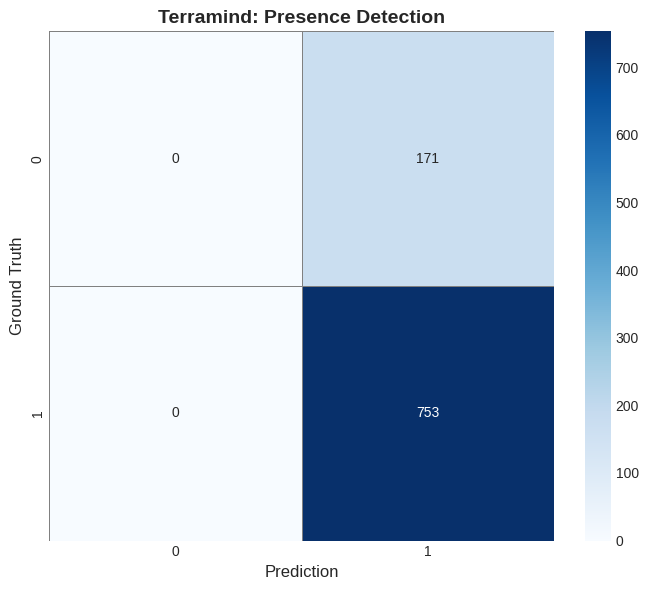

In [10]:
# Extract presence from Terramind data (any year has non-negative value)
terramind["presence"] = terramind[year_cols].apply(
    lambda row: any(is_present(v) for v in row), axis=1
).astype(int)

# Prepare GT presence
gt["presence"] = pd.to_numeric(gt["presence"], errors="coerce").fillna(0).astype(int)

# Merge
merged_presence = gt.merge(terramind[["key", "presence"]], on="key", how="inner", suffixes=("_gt", "_pred"))
print(f"Merged rows: {len(merged_presence)}")

# Create confusion matrix
cm_presence = pd.crosstab(
    merged_presence["presence_gt"], 
    merged_presence["presence_pred"], 
    rownames=["Ground Truth"], 
    colnames=["Prediction"], 
    dropna=False
).reindex(index=[0, 1], columns=[0, 1], fill_value=0)

print("\nConfusion Matrix (Presence):")
print(cm_presence)

# Calculate metrics
TN = int(cm_presence.loc[0, 0])
FP = int(cm_presence.loc[0, 1])
FN = int(cm_presence.loc[1, 0])
TP = int(cm_presence.loc[1, 1])

metrics_presence = {
    "TP": TP,
    "TN": TN,
    "FP": FP,
    "FN": FN,
    "Accuracy": (TP + TN) / max(TP + TN + FP + FN, 1),
    "Precision": TP / max(TP + FP, 1),
    "Recall": TP / max(TP + FN, 1),
    "F1-Score": (2 * TP) / max(2 * TP + FP + FN, 1),
}

print("\nMetrics:")
for k, v in metrics_presence.items():
    if isinstance(v, float):
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v}")

# Visualize
plot_confusion_matrix(
    cm_presence,
    title='Terramind: Presence Detection',
    figsize=(7, 6),
    cmap='Blues',
    save_name='terramind_presence_confusion_matrix'
)

## 2. Appearance Year (±2 Year Tolerance)

Merged rows: 924
Predictions adjusted: 701 out of 924

Confusion Matrix (Appearance Year with ±2y tolerance):
Prediction (±2y)  2014  2016  2018
Ground Truth                      
0                  146    28     0
2014               592     0     0
2016                 0   102     0
2018                29     0     7
2020                 7     1     0
2022                12     0     0

Metrics (Appearance Year with ±2y tolerance):
Accuracy: 0.7587
F1-Macro: 0.3434
F1-Weighted: 0.6598
Saved figure to: figures/terramind_appearance_year_tolerance_confusion_matrix.png


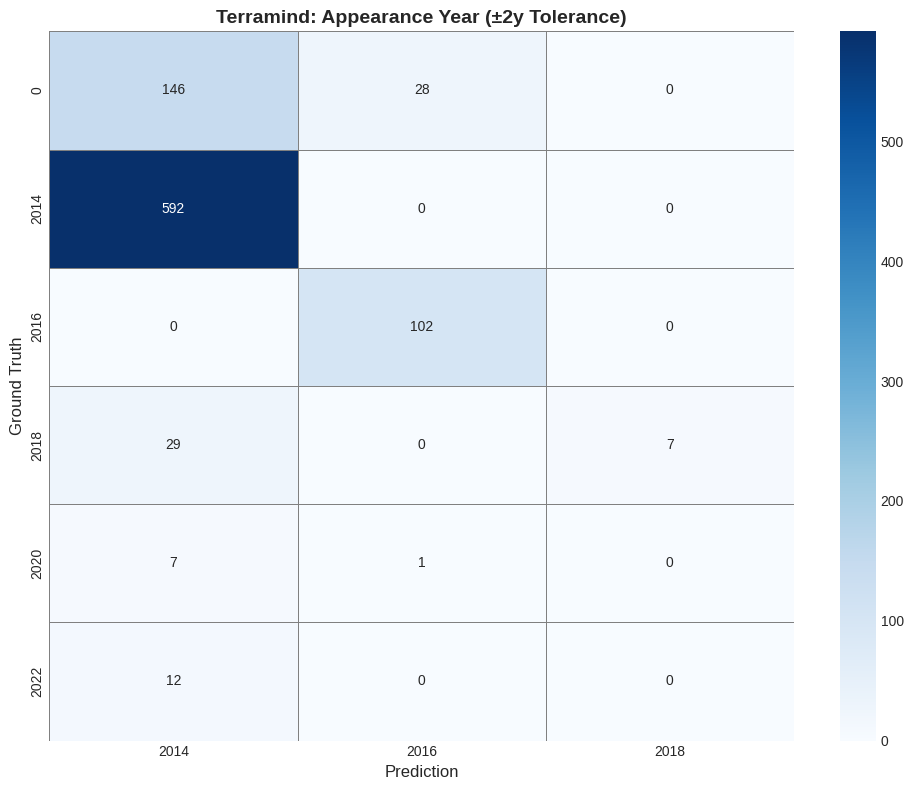

In [11]:
# Extract appearance year from Terramind data (first year with presence)
def first_present_year(row):
    for y in years:
        if is_present(row.get(str(y))):
            return y
    return 0

terramind["appearance_year"] = terramind.apply(first_present_year, axis=1).astype(int)

# Prepare GT appearance year
gt["appearance_year"] = pd.to_numeric(gt["appearance_year"], errors="coerce").fillna(0).astype(int)

# Merge
merged_appearance = gt.merge(
    terramind[["key", "appearance_year"]],
    on="key",
    how="inner",
    suffixes=("_gt", "_pred"),
)

print(f"Merged rows: {len(merged_appearance)}")

# Apply ±2 year tolerance
tol = 2
y_true = merged_appearance["appearance_year_gt"]
y_pred = merged_appearance["appearance_year_pred"].copy()

mask = (y_true - y_pred).abs() <= tol
y_pred[mask] = y_true[mask]

print(f"Predictions adjusted: {mask.sum()} out of {len(mask)}")

# Create confusion matrix
cm_appearance = pd.crosstab(
    y_true,
    y_pred,
    rownames=["Ground Truth"],
    colnames=["Prediction (±2y)"],
    dropna=False,
)

print("\nConfusion Matrix (Appearance Year with ±2y tolerance):")
print(cm_appearance)

# Calculate metrics
accuracy = (y_true == y_pred).mean()

metrics_appearance = {
    "Accuracy": accuracy,
    "F1-Macro": f1_macro(y_true, y_pred),
    "F1-Weighted": f1_weighted(y_true, y_pred),
}

print("\nMetrics (Appearance Year with ±2y tolerance):")
for k, v in metrics_appearance.items():
    print(f"{k}: {v:.4f}")

# Visualize
plot_confusion_matrix(
    cm_appearance,
    title='Terramind: Appearance Year (±2y Tolerance)',
    figsize=(10, 8),
    cmap='Blues',
    save_name='terramind_appearance_year_tolerance_confusion_matrix'
)

## 3. Transition Detection (Binary)

Merged rows: 924

Confusion Matrix (Transition Detection):
Prediction      0    1
Ground Truth          
0             214   39
1             489  182

Metrics (Transition Detection):
TP: 182
TN: 214
FP: 39
FN: 489
Accuracy: 0.4286
Precision: 0.8235
Recall: 0.2712
F1-Score: 0.4081
Saved figure to: figures/terramind_transition_detection_confusion_matrix.png


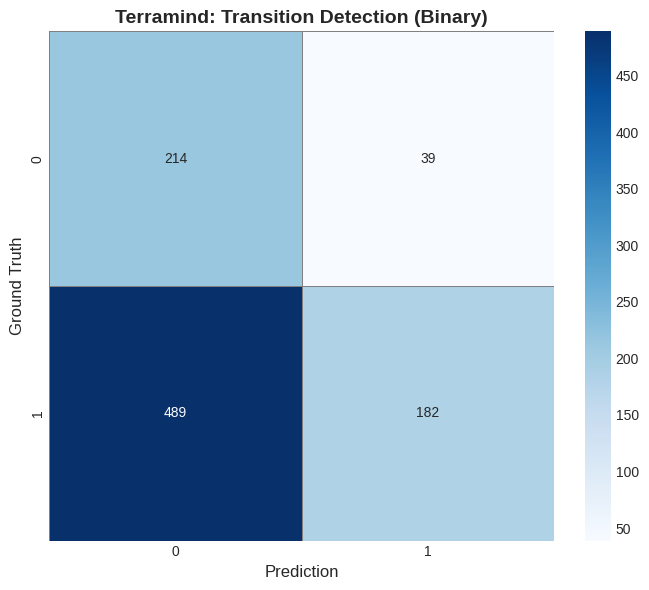

In [12]:
# Extract transition detection from Terramind data
def transition_exists(row):
    """Check if FCBK -> Zigzag transition exists"""
    # Find years with FCBK
    fcbk_years = [y for y in years if is_fcbk(row.get(str(y)))]
    if not fcbk_years:
        return 0
    
    t_fcbk = min(fcbk_years)
    
    # Find zigzag years after first FCBK
    zz_years_after = [y for y in years if y > t_fcbk and is_zigzag(row.get(str(y)))]
    if not zz_years_after:
        return 0
    
    t_zz = min(zz_years_after)
    
    # Check consistency: no FCBK after first Zigzag
    for y in years:
        if y >= t_zz and is_fcbk(row.get(str(y))):
            return 0
    
    return 1

terramind["transition"] = terramind.apply(transition_exists, axis=1).astype(int)

# Prepare GT transition
gt["transition"] = (
    pd.to_numeric(gt["fcb_to_zigzag_Category"], errors="coerce").fillna(0).astype(int) != 0
).astype(int)

# Merge
merged_transition = gt.merge(
    terramind[["key", "transition"]],
    on="key",
    how="inner",
    suffixes=("_gt", "_pred"),
)

print(f"Merged rows: {len(merged_transition)}")

# Create confusion matrix
cm_transition = pd.crosstab(
    merged_transition["transition_gt"],
    merged_transition["transition_pred"],
    rownames=["Ground Truth"],
    colnames=["Prediction"],
).reindex(index=[0, 1], columns=[0, 1], fill_value=0)

print("\nConfusion Matrix (Transition Detection):")
print(cm_transition)

# Calculate metrics
TN_trans = int(cm_transition.loc[0, 0])
FP_trans = int(cm_transition.loc[0, 1])
FN_trans = int(cm_transition.loc[1, 0])
TP_trans = int(cm_transition.loc[1, 1])

metrics_transition = {
    "TP": TP_trans,
    "TN": TN_trans,
    "FP": FP_trans,
    "FN": FN_trans,
    "Accuracy": (TP_trans + TN_trans) / max(TP_trans + TN_trans + FP_trans + FN_trans, 1),
    "Precision": TP_trans / max(TP_trans + FP_trans, 1),
    "Recall": TP_trans / max(TP_trans + FN_trans, 1),
    "F1-Score": (2 * TP_trans) / max(2 * TP_trans + FP_trans + FN_trans, 1),
}

print("\nMetrics (Transition Detection):")
for k, v in metrics_transition.items():
    if isinstance(v, float):
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v}")

# Visualize
plot_confusion_matrix(
    cm_transition,
    title='Terramind: Transition Detection (Binary)',
    figsize=(7, 6),
    cmap='Blues',
    save_name='terramind_transition_detection_confusion_matrix'
)

## 4. Transition Year (±2 Year Tolerance)

Merged rows: 924
Predictions adjusted: 55 out of 924

Confusion Matrix (Transition Year with ±2y tolerance):
Prediction (±2y)  0     2016  2018  2020  2022  2024
Ground Truth                                        
0                  214     7     7     9     8     8
2016                 2     0     0     0     0     0
2018                45     0     4     0     0     0
2020               139    38     0    22     0     1
2022               268    47    25     0    24     0
2023                 1     0     0     0     0     0
2024                34    12     3     1     0     5

Metrics (Transition Year with ±2y tolerance):
Accuracy: 0.2911
F1-Macro: 0.1421
F1-Weighted: 0.2248
Saved figure to: figures/terramind_transition_year_tolerance_confusion_matrix.png


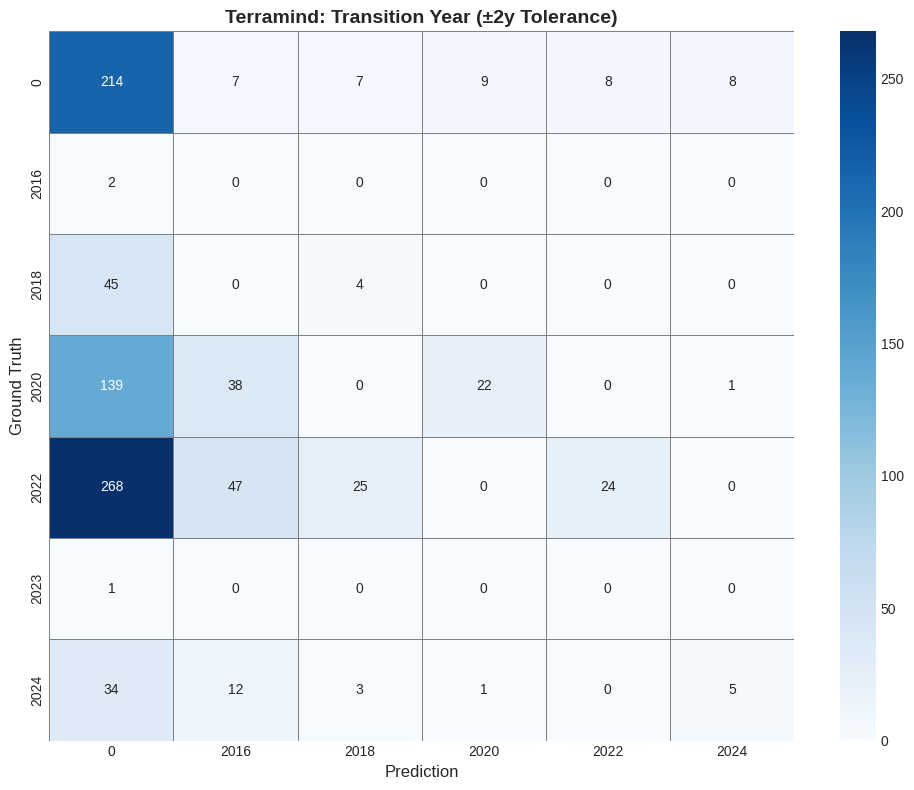

In [13]:
# Extract transition year from Terramind data
def transition_year(row):
    """Get the year when FCBK -> Zigzag transition occurred"""
    # Find years with FCBK
    fcbk_years = [y for y in years if is_fcbk(row.get(str(y)))]
    if not fcbk_years:
        return 0
    
    t_fcbk = min(fcbk_years)
    
    # Find zigzag years after first FCBK
    zz_years_after = [y for y in years if y > t_fcbk and is_zigzag(row.get(str(y)))]
    if not zz_years_after:
        return 0
    
    t_zz = min(zz_years_after)
    
    # Check consistency: no FCBK after first Zigzag
    for y in years:
        if y >= t_zz and is_fcbk(row.get(str(y))):
            return 0
    
    return t_zz

terramind["transition_year"] = terramind.apply(transition_year, axis=1).astype(int)

# Prepare GT transition year
gt["transition_year"] = pd.to_numeric(gt["fcb_to_zigzag_Category"], errors="coerce").fillna(0).astype(int)

# Merge
merged_transition_year = gt.merge(
    terramind[["key", "transition_year"]],
    on="key",
    how="inner",
    suffixes=("_gt", "_pred"),
)

print(f"Merged rows: {len(merged_transition_year)}")

# Apply ±2 year tolerance
tol = 2
y_true_trans = merged_transition_year["transition_year_gt"].values
y_pred_trans = merged_transition_year["transition_year_pred"].values.copy()

# Adjust predictions within ±2 years to match ground truth
mask_trans = (y_true_trans != 0) & (y_pred_trans != 0) & (np.abs(y_pred_trans - y_true_trans) <= tol)
y_pred_trans[mask_trans] = y_true_trans[mask_trans]

print(f"Predictions adjusted: {mask_trans.sum()} out of {len(mask_trans)}")

# Create confusion matrix
cm_transition_year = pd.crosstab(
    y_true_trans,
    y_pred_trans,
    rownames=["Ground Truth"],
    colnames=["Prediction (±2y)"],
    dropna=False,
)

print("\nConfusion Matrix (Transition Year with ±2y tolerance):")
print(cm_transition_year)

# Calculate metrics
accuracy_trans = (y_true_trans == y_pred_trans).mean()

metrics_transition_year = {
    "Accuracy": accuracy_trans,
    "F1-Macro": f1_macro(y_true_trans, y_pred_trans),
    "F1-Weighted": f1_weighted(y_true_trans, y_pred_trans),
}

print("\nMetrics (Transition Year with ±2y tolerance):")
for k, v in metrics_transition_year.items():
    print(f"{k}: {v:.4f}")

# Visualize
plot_confusion_matrix(
    cm_transition_year,
    title='Terramind: Transition Year (±2y Tolerance)',
    figsize=(10, 8),
    cmap='Blues',
    save_name='terramind_transition_year_tolerance_confusion_matrix'
)

In [ ]:
# ● Perfect! The Terramind performance analysis has completed successfully. Here are the results:

#   Terramind Model Performance Summary

#   1. Presence Detection (Binary)

#   - Accuracy: 81.49%
#   - F1-Score: 89.80%
#   - Precision: 81.49%
#   - Recall: 100%
#   - Confusion Matrix: TP=753, TN=0, FP=171, FN=0
#   - Issue: Model predicts all locations as having kilns (no true negatives), leading to many false positives

#   2. Appearance Year (±2 Year Tolerance)

#   - Accuracy: 75.87%
#   - Predictions adjusted: 701 out of 924
#   - Distribution:
#     - Strong performance on 2014 (592 correct)
#     - Good on 2016 (102 correct)
#     - Struggles with later years (2018-2024)

#   3. Transition Detection (Binary)

#   - Accuracy: 42.86%
#   - F1-Score: 40.81%
#   - Precision: 82.35%
#   - Recall: 27.12% ⚠️
#   - Confusion Matrix: TP=182, TN=214, FP=39, FN=489
#   - Issue: Very low recall - misses 489 out of 671 actual transitions (73% miss rate)

#   4. Transition Year (±2 Year Tolerance)

#   - Accuracy: 29.11% ⚠️
#   - Predictions adjusted: 55 out of 924
#   - Issue: Very poor performance - mostly predicts no transition when one exists

#   Key Findings:

#   1. ✅ Good at detecting kiln presence
#   2. ✅ Reasonable at identifying appearance years (especially early years)
#   3. ❌ Poor at detecting transitions (misses 73% of actual FCBK→Zigzag transitions)
#   4. ❌ Very poor at predicting transition years

#   The model appears to be conservative in predicting transitions, resulting in high precision but very low recall.